In [59]:
## implementation & testing --> v1

import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F
torch.manual_seed(1337)

print('IMPORTS DONE')

IMPORTS DONE


In [60]:
## start with data
data = open('/Users/joesasson/Desktop/open-source/numpy-RNN/data/input.txt', 'r').read() # should be simple plain text file

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)

print('data has {} characters, {} unique.'.format(data_size, vocab_size))

char_to_idx = { ch:i for i,ch in enumerate(chars) }
idx_to_char = { i:ch for i,ch in enumerate(chars) }

data has 1115394 characters, 65 unique.


In [69]:
from typing import Any
np.random.seed(99)

class RNN:
    def __init__(self, hidden_size, vocab_size, seq_length):
        self.name = 'RNN'
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # model parameters
        self.Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
        self.Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
        self.Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
        self.bh = np.zeros((hidden_size, 1)) # hidden bias
        self.by = np.zeros((vocab_size, 1)) # output bias

        # memory variables for training (ada grad from karpathy's github)
        self.iteration, self.pointer = 0, 0
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh) 
        self.mWhy = np.zeros_like(self.Why)
        self.mbh, self.mby = np.zeros_like(self.bh), np.zeros_like(self.by)
        self.loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

        self.running_loss = []

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        """RNN Forward Pass"""

        x, y, hprev = kwds['inputs'], kwds['targets'], kwds['hprev']

        lr = kwds['lr']

        loss = 0
        xs, hs, ys, ps = {}, {}, {}, {} # inputs, hidden state, output, probabilities
        hs[-1] = np.copy(hprev)

        # forward pass
        for t in range(len(x)):
            xs[t] = np.zeros((self.vocab_size,1)) # encode in 1-of-k representation
            xs[t][x[t]] = 1
            hs[t] = np.tanh(np.dot(self.Wxh, xs[t]) + np.dot(self.Whh, hs[t-1]) + self.bh) # hidden state
            ys[t] = np.dot(self.Why, hs[t]) + self.by # unnormalized log probabilities for next chars
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
            loss += -np.log(ps[t][y[t],0]) # softmax (cross-entropy loss)

        # backward pass: compute gradients going backwards
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])

        for t in reversed(range(len(x))):
            dy = np.copy(ps[t])
            dy[y[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dhnext # backprop into h
            dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
            dbh += dhraw
            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t-1].T)
            dhnext = np.dot(self.Whh.T, dhraw)

        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients

        # perform parameter update with Adagrad
        for param, dparam, mem in zip([self.Wxh, self.Whh, 
                                        self.Why, self.bh, self.by], 
                                        [dWxh, dWhh, dWhy, dbh, dby], 
                                        [self.mWxh, self.mWhh, 
                                        self.mWhy, self.mbh, self.mby]):
            
            mem += dparam * dparam
            param += -lr * dparam / np.sqrt(mem + 1e-8) # adagrad update

        self.running_loss.append(loss)

        return loss, hs[len(x)-1]

In [71]:
## hyper-params
seq_length = 8
hidden_size = 100

rnn = RNN(hidden_size=hidden_size, vocab_size=vocab_size, seq_length=seq_length)

def train(rnn, epochs, data, lr=1e-1):

    for _ in range(epochs):

        # prepare inputs (we're sweeping from left to right in steps seq_length long)
        if rnn.pointer+seq_length+1 >= len(data) or rnn.iteration == 0: 
            hprev = np.zeros((hidden_size,1)) # reset RNN memory
            p = 0 # go from start of data

        x = [char_to_idx[ch] for ch in data[rnn.pointer:rnn.pointer+seq_length]]
        y = [char_to_idx[ch] for ch in data[rnn.pointer+1:rnn.pointer+seq_length+1]]

        # forward / backward pass single batch through network
        loss, hprev = rnn(inputs=x, targets=y, hprev=hprev, lr=lr)

        # update loss
        rnn.loss = rnn.loss * 0.999 + loss * 0.001

        ## show progress now and then
        if rnn.iteration % 1000 == 0: 
            print('iter {}, loss: {}'.format(rnn.iteration, rnn.loss))

        rnn.pointer += seq_length # move data pointer
        rnn.iteration += 1 # iteration counter 

        
train(rnn=rnn, epochs=50000, data=data)

iter 0, loss: 33.395094070440024
iter 1000, loss: 29.379218839627327
iter 2000, loss: 25.17416419502023
iter 3000, loss: 22.61450461254302
iter 4000, loss: 20.660814605417286
iter 5000, loss: 19.919109624973792
iter 6000, loss: 19.15566225873854
iter 7000, loss: 18.763769403137267
iter 8000, loss: 18.095497552995337
iter 9000, loss: 17.639523810450594
iter 10000, loss: 17.340856935590434
iter 11000, loss: 17.08206805146112
iter 12000, loss: 17.066448585811024
iter 13000, loss: 17.146039640819073
iter 14000, loss: 17.271898579973332
iter 15000, loss: 17.07930126331246
iter 16000, loss: 17.09351224475144
iter 17000, loss: 17.264674459927843
iter 18000, loss: 17.25991142837826
iter 19000, loss: 17.020276580985247
iter 20000, loss: 17.854637302808857
iter 21000, loss: 17.31078289614911
iter 22000, loss: 17.2949790385274
iter 23000, loss: 17.123846618796865
iter 24000, loss: 17.004164940543735
iter 25000, loss: 16.673152657095187
iter 26000, loss: 16.719664934590718
iter 27000, loss: 16.932

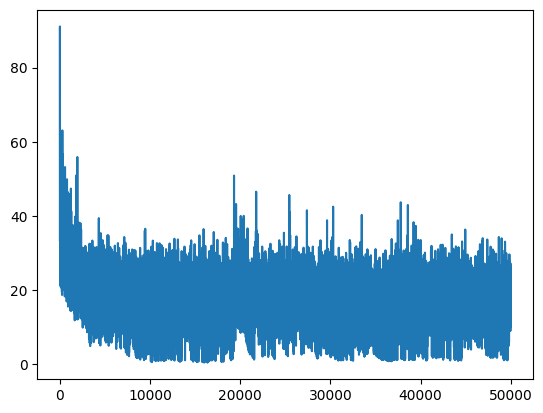

In [72]:
import matplotlib.pyplot as plt 

plt.plot(rnn.running_loss)